<a href="https://colab.research.google.com/github/egorik3z/ML/blob/master/ML31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Импорт необходимых модулей 
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Настройки для визуализации
# Если используется темная тема - лучше текст сделать белым
TEXT_COLOR = 'black'

matplotlib.rcParams['figure.figsize'] = (15, 10)
matplotlib.rcParams['text.color'] = 'black'
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.labelcolor'] = TEXT_COLOR
matplotlib.rcParams['xtick.color'] = TEXT_COLOR
matplotlib.rcParams['ytick.color'] = TEXT_COLOR

# Зафиксируем состояние случайных чисел
RANDOM_STATE = 0
np.random.seed(RANDOM_STATE)

# Решающее дерево для классификации¶
Для того, чтобы разобраться, как деревья строятся, посмотрим на набор данных из двух признаков (чтобы была возможность визуализации):

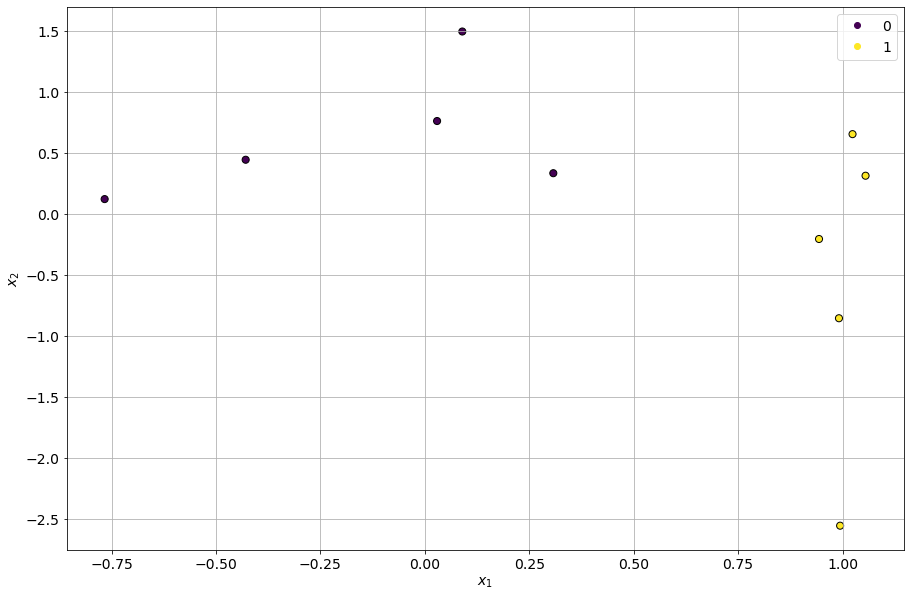

In [31]:

from sklearn.datasets import make_classification

X_data, y_data = make_classification(
    n_samples=10,
    n_features=2, 
    n_redundant=0,
    n_informative=1, 
    n_clusters_per_class=1,
    random_state=RANDOM_STATE
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

# Примеси Джини (Gini impurity)¶

In [32]:
  # TODO - напишите реализацию функции вычисления Джини
def gini_impurity(y):
    if (len(y)==0):
      return 0
    p0=len(y[y==1])/len(y)
    p1=len(y[y==0])/len(y)
    gini=p0*(1-p0)+p1*(1-p1)
    return gini

In [33]:
# TEST
y1 = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
y2 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
y3 = np.array([0, 0, 1, 1, 1, 1, 1, 1, 1, 1])
y4 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

assert gini_impurity(y1) == 0.5
assert gini_impurity(y2) == 0
assert gini_impurity(y3) == 0.32
assert gini_impurity(y4) == 0
assert gini_impurity(np.array([])) == 0

Для чего нам нужен этот показатель? Суть решающего дерева заключается в том, что каждым узлом производится раздел пространства на части. То есть, если мы говорим, что узел разделяет по признаку $x_1$ с порогом 0.5, то все пространство правее линии $x_1 = 0.5$ становится классом 1, а все левее этой линии - классом 0. Для проверки напишем первый вариант функции предсказания и построим визуализацию решений модели.

In [34]:
# TODO
def predict_v1(X):
    # Напишите реализацию функции предсказания
    #   решающего дерева с одним узлом
    #   разделение по признаку (x1) с порогом 0.5
    # *Не забывайте о размерности данных X
    y_pred=np.zeros_like(X[:,0])
    y_pred[X[:,0]>0.5]=1
    return y_pred

In [35]:
# TEST
X = np.array([
    [1, 1],
    [2, 1],
    [0, 1],
])

assert np.all(predict_v1(X) == np.array([1, 1, 0]))

Теперь вернемся к нашим данным и посмотрим, как работает предсказание разделением по единственному признаку:

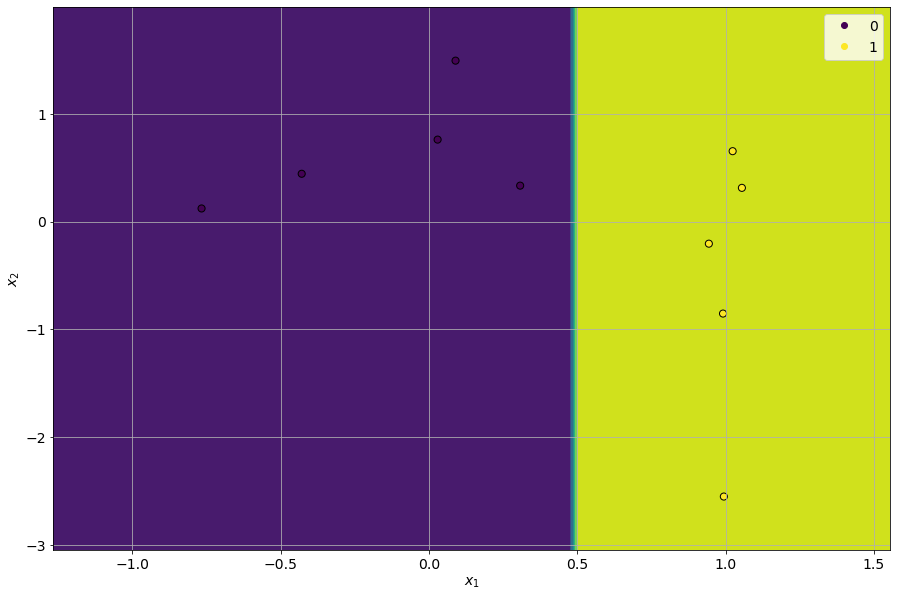

In [36]:
X = X_data
y_true = y_data

x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
xx, yy = np.meshgrid(x1_vals, x2_vals)
space_X = np.c_[xx.ravel(), yy.ravel()]

y_pred = predict_v1(space_X)
y_pred = y_pred.reshape(xx.shape)

plt.contourf(xx, yy, y_pred)
pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.show()

Как видно, реализация дерева с одним узлом разделяет пространство решений на две части. Если добавить еще узлов в дерево, то разделение будет продолжаться прямыми линиями дальше (это мы увидим в дальнейших шагах).

Сейчас важно понять, как нам создать такое разделение автоматически?

Для начала, мы же не знаем лучшее разделение из данных - нам надо получить его автоматически. Попробуем три разных порога для разделения данных по признаку $x_1$ (который стоит в колонке 0) и посчитаем примеси Джини каждой части после разделения:

In [37]:
thresholds = [-0.5, 0.5, 1]
feature_index = 0

X = X_data
y_true = y_data

gini_full = gini_impurity(y_true)
print(f'Gini full: {gini_full} | count: {len(y_true)}')

for threshold in thresholds:
    print(f'\tSplit by {threshold}')
    split_mask = X[:, feature_index] > threshold
    y_true_left = y_true[split_mask]
    y_true_right = y_true[~split_mask]
    
    gini_left = gini_impurity(y_true_left)
    gini_right = gini_impurity(y_true_right)

    print(f'\t\tGini left: {gini_left} | element count: {len(y_true_left)}')
    print(f'\t\tGini right: {gini_right} | element count: {len(y_true_right)}')

Gini full: 0.5 | count: 10
	Split by -0.5
		Gini left: 0.49382716049382713 | element count: 9
		Gini right: 0.0 | element count: 1
	Split by 0.5
		Gini left: 0.0 | element count: 5
		Gini right: 0.0 | element count: 5
	Split by 1
		Gini left: 0.0 | element count: 2
		Gini right: 0.46875 | element count: 8


In [38]:
thresholds = [-0.5, 0.5, 1]
feature_index = 0

X = X_data
y_true = y_data

gini_full = gini_impurity(y_true)
print(f'Gini full: {gini_full}')

for threshold in thresholds:
    print(f'\tSplit by {threshold}')
    split_mask = X[:, feature_index] > threshold
    y_true_left = y_true[split_mask]
    y_true_right = y_true[~split_mask]
    
    gini_left = gini_impurity(y_true_left)
    gini_right = gini_impurity(y_true_right)

    print(f'\t\tGini left: {gini_left}')
    print(f'\t\tGini right: {gini_right}')
    
    weight_left = len(y_true_left)/len(y_true)
    weight_right = len(y_true_right)/len(y_true)
    weighted_gini = weight_left * gini_left + weight_right * gini_right
    print(f'\t\tGini after split: {weighted_gini}')
    print(f'\t\tGini gain: {gini_full-weighted_gini}')

Gini full: 0.5
	Split by -0.5
		Gini left: 0.49382716049382713
		Gini right: 0.0
		Gini after split: 0.4444444444444444
		Gini gain: 0.05555555555555558
	Split by 0.5
		Gini left: 0.0
		Gini right: 0.0
		Gini after split: 0.0
		Gini gain: 0.5
	Split by 1
		Gini left: 0.0
		Gini right: 0.46875
		Gini after split: 0.375
		Gini gain: 0.125


# Выбор лучшего разделения (сплита)¶

Ответ: ничего особенного, мы будем делать жадный перебор =)

Почему? Да потому что это просто! То есть, суть алгоритма выбора признака для разделения и порога по этому признаку будет заключаться в том, что мы будем перебирать каждый индекс признака и в рамках этого признака - каждую запись в качестве порога.

То есть, в качестве псевдокода можно записать так:

Цикл по всем признакам
    Цикл по всем записям
        Берем значение признака в этой записи в качестве порога
        Делаем разделение
        Вычисляем примеси Джини
        Если прирост Джини больше, чем сохраненный,
            то сохранить индекс признака и значение порога,
            а также обновить лучшую примесь 
            и взвешенную сумму примесей
А теперь, реализуйте его в качестве функции:

In [39]:
def get_best_split(X, y_true):
    best_gini_gain = 0
    best_gini_impurity = 0
    best_feature_idx = 0
    best_threshold = 0
    gini_full = gini_impurity(y_true)
    # TODO - дополните реализацию функции получения наилучшего разделения
    for feat in range(X.shape[1]):
      for dat in range(X.shape[0]):
        split_mask = X[:, feat] > X[dat,feat]
        y_true_left = y_true[split_mask]
        y_true_right = y_true[~split_mask]

        gini_left = gini_impurity(y_true_left)
        gini_right = gini_impurity(y_true_right)
        
        weight_left = len(y_true_left)/len(y_true)
        weight_right = len(y_true_right)/len(y_true)
        weighted_gini = weight_left * gini_left + weight_right * gini_right
        gini_gain=gini_full-weighted_gini
        if (gini_gain>best_gini_gain):
          best_gini_gain=gini_gain
          best_threshold=X[dat,feat]
          best_feature_idx=feat
          best_gini_impurity=weighted_gini
    return best_gini_impurity, best_feature_idx, best_threshold

In [40]:
# TEST
X = np.array([1, 2, 3, 4, 5, 6, 7, 8]).reshape(-1, 1)
y = np.array([1, 1, 1, 1, 0, 0, 0, 1])

best_gini, best_feature_idx, best_threshold = get_best_split(X, y)

assert np.isclose(best_gini, 0.1875)
assert np.isclose(best_threshold, 4)
assert best_feature_idx == 0

In [41]:
best_gini, best_feature_idx, best_threshold = get_best_split(X_data, y_data)

print(
    f"Best gini impurity:\t{best_gini}",
    f"\nBest feature index:\t{best_feature_idx}",
    f"\nBest threshold value:\t{best_threshold}"
)

Best gini impurity:	0.0 
Best feature index:	0 
Best threshold value:	0.3074493077524587


In [42]:
# TODO
def predict_v2(X, feature_index, threshold):
    # Напишите реализацию функции предсказания
    #   решающего дерева с одним узлом
    #   разделение по признаку (x1) с порогом 0.5
    # *Не забывайте о размерности данных X
    y_pred=np.zeros_like(X[:,feature_index])
    y_pred[X[:,feature_index]>threshold]=1
    return y_pred

In [43]:
# TEST
X = X_data
y_true = y_data

y_pred = predict_v2(X, best_feature_idx, best_threshold)
assert np.all(y_true == y_pred)

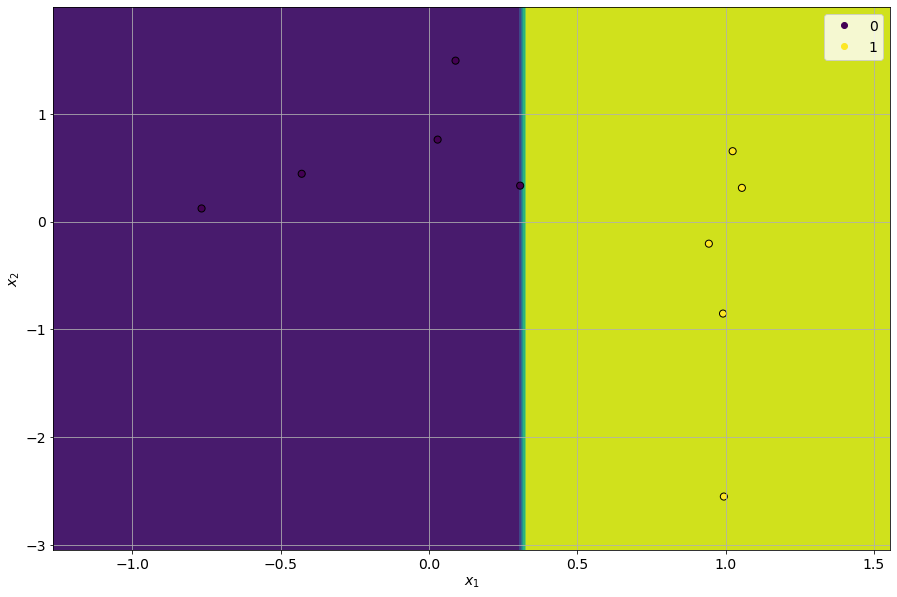

In [44]:
X = X_data
y_true = y_data

x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 100)
x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 100)
xx, yy = np.meshgrid(x1_vals, x2_vals)
space_X = np.c_[xx.ravel(), yy.ravel()]

y_pred = predict_v2(space_X, best_feature_idx, best_threshold)
y_pred = y_pred.reshape(xx.shape)

plt.contourf(xx, yy, y_pred)
pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])
plt.show()

Как мы видим, лучшее разделение не произвело деление по 0.5, но тем не менее был найден такой признак и порог для него, который верно разделил все данные в наборе.

Это отличный результат для автоматического построения решающего дерева, состоящего из одного корневого узла. Маленькими шагами мы идем от березки к огромным кедрам!

# Представление структуры дерева

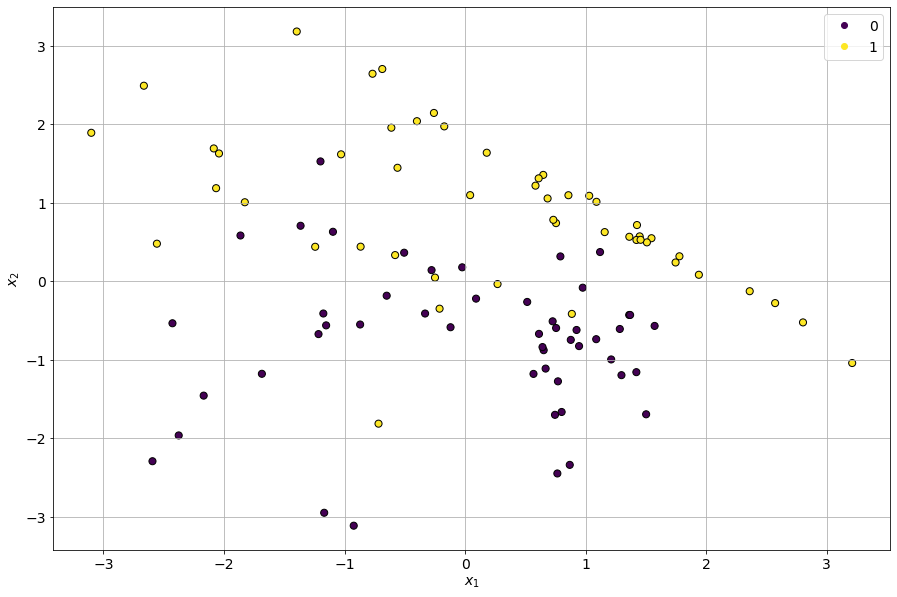

In [45]:
X_data, y_data = make_classification(
    n_samples=100,
    n_features=2, 
    n_redundant=0,
    n_informative=2, 
    n_clusters_per_class=2,
    random_state=3
)

pnts_scatter = plt.scatter(X_data[:, 0], X_data[:, 1], marker='o', c=y_data, s=50, edgecolor='k', )
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.grid(True)
plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1'])

Метод получения информации о глубине .get_max_depth() просто вернет глубину листа, на котором он находится.

In [46]:
class DecisionLeaf:
    def __init__(self, depth):
        ''' Конструктор класса
        Аргументы
        ---------
            depth: int
                глубина листа, на котором он располагается
        '''
        self.predict_class = None
        self.depth = depth

    def predict(self, X):
        ''' Функция предсказания листа

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний, заполненный значениями
                класса листа
        '''
        # TODO - напишите функцию предсказания
        y_pred=np.full(X.shape[0],self.predict_class)
        return y_pred

    def fit(self, X, y):
        ''' Метод находит в данных класс с наибольшим количеством записей
            и присваивает его листу как наиболее вероятно 
            предсказываемый класс
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''
        # TODO - напишите функцию обучения
        # Выбираем из y наиболее часто встречающееся значение 
        #   и присваиваем self.predict_class
        #   это и будет предсказываемый класс листа
        class1=np.unique(y)
        for i in class1:
          if(len([y==self.predict_class])<len(y[y==i])):
            self.predict_class=i

    def get_max_depth(self):
        ''' Получение информации о максимальной глубине
        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        # TODO - напишите функцию возврата глубины, на которой находится лист
        return self.depth

    def print(self):
        ''' Вывод информации о листе '''
        print(f'{self.depth*" "}> Class {self.predict_class}')

In [47]:
# TEST
leaf = DecisionLeaf(1)

assert leaf.get_max_depth() == 1

X = np.array([1, 1, 1, 3]).reshape(-1, 1)
y = np.array([0, 1, 1, 2])
leaf.fit(X, y)

y_pred = leaf.predict(X)
y_true = np.array([1, 1, 1, 1])

assert np.all(y_pred == y_true)
assert np.all(y_pred.shape == y_true.shape)

После построения надо сделать реализацию метода предсказания. Метод предсказания .predict() будет заключаться в том, чтобы разделить поступившие для предсказания данные и передать части в соответсвующие ветки дальше для .predict().

In [48]:
class DecisionNode:
    def __init__(self, depth, depth_limit, min_samples_split):
        ''' Конструктор класса
        Аргументы
        ---------
            depth: int
                глубина узла, на которой он располагается

            depth_limit: int
                максимальная глубина дерева
            
            min_samples_split: int
                минимальное количество записей для создания узла
        '''
        # Глубина, на которой узел находится
        self.depth = depth
        # Максимальная глубина
        self.depth_limit = depth_limit
        # Минимальное количество записей после сплита, чтобы создать узел
        self.min_samples_split = min_samples_split
        # Индекс признака, по которому узел делает разделение
        self.feature_index = None
        # Порог для разделения
        self.threshold = None

        # Аттрибуты для веток (правая ~ true, левая ~ false)
        self.true_elem = None
        self.false_elem = None
    
    def _create_new_element(self, X, y):
        ''' Метод создания нового элемента
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''
        # Если в разметке остались уникальные классы - создаем лист
        if len(set(y)) == 1:
            return DecisionLeaf(self.depth+1)
        # TODO - допишите ограничения 
        #   на минимальное количество записей в данных
        #   и ограничение глубины
        if (len(y)<=self.min_samples_split):
            return DecisionLeaf(self.depth+1)
        if (self.depth>=self.depth_limit-1):
            return DecisionLeaf(self.depth+1)

        # Если так и не вернули лист - то возвращаем узел
        # У него увеличиваем глубину на 1 и пробрасываем инфу об ограничениях
        return DecisionNode(
            self.depth+1, 
            self.depth_limit,
            self.min_samples_split
        )

    def predict(self, X):
        ''' Функция предсказания узла

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        # TODO - напишите реализацию метода предсказания

        # Получите маску разделения
        mask = X[:, self.feature_index] > self.threshold
        right_X = X[mask]
        left_X=X[~mask]
        # Вот формируем вектор предсказания
        prediction = np.ndarray(X.shape[0], dtype=int)

        # Вот заполняем предсказания одной ветви
        prediction[~mask] = self.false_elem.predict(left_X)
        prediction[mask] = self.true_elem.predict(right_X)
        # Сделайте заполнения для второй ветви
        print(prediction[mask])

        return prediction
    def get_best_split(self, X, y_true):
        best_gini_gain = 0
        best_gini_impurity = 0
        best_feature_idx = 0
        best_threshold = 0
        gini_full = gini_impurity(y_true)
        # TODO - дополните реализацию функции получения наилучшего разделения
        for fear in range(X.shape[1]):
          for dat in range(X.shape[0]):
            split_mask = X[:, fear] > X[dat,fear]
            y_true_left = y_true[split_mask]
            y_true_right = y_true[~split_mask]

            gini_left = gini_impurity(y_true_left)
            gini_right = gini_impurity(y_true_right)
            
            weight_left = len(y_true_left)/len(y_true)
            weight_right = len(y_true_right)/len(y_true)
            weighted_gini = weight_left * gini_left + weight_right * gini_right
            gini_gain=gini_full-weighted_gini
            if (gini_gain>best_gini_gain):
              best_gini_gain=gini_gain
              best_threshold=X[dat,fear]
              best_feature_idx=fear
              best_gini_impurity=weighted_gini
        return best_feature_idx, best_threshold
    def fit(self, X, y):
        ''' Метод обучения узла
        
        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных для обучения 
            y : ndarray [n_samples]
                вектор истинных значений классов  
        '''
        # TODO - напишите реализацию метода обучения

        # Получите лучший сплит

        # Сохраните параметры сплита в self.feature_index и self.threshold
        self.feature_index, self.threshold = self.get_best_split(X, y)
        # Вот здесь мы создаем маску для деления
        mask = X[:, self.feature_index] > self.threshold
        right_X = X[mask]
        right_y = y[mask]

        self.true_elem = self._create_new_element(right_X, right_y)
        self.true_elem.fit(right_X, right_y)
        
        # Вам нужно сделать аналогичные действия для другой ветки
        
        left_X = X[~mask]
        left_y = y[~mask]

        self.false_elem = self._create_new_element(left_X, left_y)
        self.false_elem.fit(left_X, left_y)

    def get_max_depth(self):
        ''' Получение информации о максимальной глубине
        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        # Берем максимум от максимальной глубины по веткам
        return max([
            self.true_elem.get_max_depth(), 
            self.false_elem.get_max_depth()
        ])
    
    def print(self):
        ''' Вывод информации об узле '''
        print(f'{self.depth*" "}| {self.feature_index} > {self.threshold}')
        self.true_elem.print()
        self.false_elem.print()

In [49]:
# TEST
# Допустим, что узел на уровне 1 и максимальная глубина = 2
# Ограничение на минимальное количество уберем
node = DecisionNode(1, 2, 0)

X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([0, 0, 1, 1, 0])
node.fit(X, y)

y_pred = node.predict(X)
y_true = np.array([0, 0, 1, 1, 1])

assert node.get_max_depth() == 2
assert np.all(y_pred == y_true)
assert np.all(y_pred.shape == y_true.shape)

[1 1 1]


In [50]:

class DecisionTree:
    def __init__(self, depth_limit, min_samples_split):
        ''' Конструктор класса
        
        Аргументы
        ---------
            depth_limit: int
                максимальная глубина дерева
            
            min_samples_split: int
                минимальное количество записей для создания узла
        '''
        self.root = DecisionNode(0, depth_limit, min_samples_split)

    def predict(self, X):
        ''' Функция предсказания узла

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных

        Возвращает
        ----------
            predict: ndarray [n_samples]
                вектор предсказаний
        '''
        return self.root.predict(X)

    def fit(self, X, y):
        ''' Функция обучения

        Аргументы
        ---------
            X : ndarray [n_samples, n_features]
                матрица данных
        '''
        self.root.fit(X, y)

    def get_depth(self):
        ''' Получение информации о глубине дерева

        Возвращает
        ----------
            depth: int
                глубина листа        
        '''
        return self.root.get_max_depth()
    
    def print(self):
        ''' Вывод информации о дереве '''
        self.root.print()

In [51]:
# TEST
X = X_data
y_true = y_data

# Снимем ограничения дерева
# Не ограничиваем глубину и минимальное кол-во записей для узла
tree = DecisionTree(100, 0)
tree.fit(X,y_true)

assert tree.get_depth() == 6

In [52]:
tree.print()

| 1 > -0.18139161596997877
 | 1 > 0.3745125530056157
  | 0 > -1.096615964304849
   > Class 1
   | 0 > -1.2439900718574142
    > Class 0
    | 1 > 0.7091967442272131
     > Class 1
     | 1 > 0.4809573472262809
      > Class 0
      > Class 1
  | 0 > 1.1187257041052354
   > Class 1
   | 0 > -0.5810000805093616
    | 1 > 0.04912870149405335
     > Class 0
     | 0 > 0.26842648043447426
      > Class None
      > Class 1
    > Class None
 | 0 > 1.5712194041070418
  > Class 1
  | 1 > -0.42680267791699533
   | 0 > 0.5144652486005934
    > Class None
    | 0 > -0.3325225345080114
     | 0 > -0.21235292176894527
      > Class 0
      > Class None
     > Class 0
   | 1 > -1.8111327315138177
    > Class 0
    | 1 > -1.9609526821607552
     > Class None
     > Class 0


Если дерево обучилось, тест на соответствующую глубину пройден - можно взглянуть на пространство принятия решений:

In [56]:
def plot_tree_decision_space(X, y_true, tree):
    x1_vals = np.linspace(X[:,0].min()-0.5, X[:,0].max()+0.5, 300)
    x2_vals = np.linspace(X[:,1].min()-0.5, X[:,1].max()+0.5, 300)
    xx, yy = np.meshgrid(x1_vals, x2_vals)
    space_X = np.c_[xx.ravel(), yy.ravel()]

    y_pred = tree.predict(space_X)
    y_pred = y_pred.reshape(xx.shape)

    plt.contourf(xx, yy, y_pred)
    pnts_scatter = plt.scatter(X[:, 0], X[:, 1], c=y_true, s=50, edgecolor='k')
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(True)
    plt.legend(handles=pnts_scatter.legend_elements()[0], labels=['0', '1', '2'])
    plt.show()

In [54]:
plot_tree_decision_space(X, y_true, tree)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

In [55]:
y_pred = tree.predict(X)
(y_pred != y_true).sum()

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

# Задание
Определите наилучшие показатели для дерева с ограничением по показателю f1 кроссвалидацией путем перебора двух параметров. Постройте таблицу и отобразите ее с помощью seaborn.heatmap().

In [57]:
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold 

def cross_val_score_f1(model, k_folds, X, y):
    f1_values = []
    # TODO - напишите функцию получения оценки кросс-валидацией
    
    return np.mean(f1_values)

In [58]:
X = X_data
y_true = y_data

for depth_limit in range(1, 7):
    for min_samples in range(0, 20, 2):
        tree = DecisionTree(depth_limit=depth_limit, min_samples_split=min_samples)
        f1_value = cross_val_score_f1(tree, 5, X, y_true)

# TODO - Добавьте сохранение данных и отображение таблицы

E:\jupytttt\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
E:\jupytttt\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# Бэггинг (bagging)

Для практики реализуем метод генерации бутстрэп выборок из исходных данных:

In [59]:
def generate_bootstrap_sets(X, D):
    ''' Генерация D выборок из исходных данных

    Параметры
    ---------
    X: [n_samples, n_features]
        Исходные данные
    
    D: int
        Количество выборок для генерации

    Возвращает
    ----------
    boostrapped_sets: list
        Список, состоящий из бутстрэп-выборок данных размером [n_samples, n_features]
    ''' 

    bootstrapped_sets = []
    # TODO - напишите реализацию генератора выборок
    return bootstrapped_sets

In [60]:
X = np.array([
    [1, 2, 3],
    [5, 7, 9],
    [-2, 0, 3],
    [-1, 9, 2],
])

boostrapped_Xs = generate_bootstrap_sets(X, 3)

assert len(boostrapped_Xs) == 3
assert boostrapped_Xs[0].shape == X.shape
assert boostrapped_Xs[1].shape == X.shape
assert boostrapped_Xs[2].shape == X.shape

AssertionError: 

# Бэггинг над решающими деревьями

После реализации функции генерации бутстрэп выборок мы можем проверить работоспособность подхода ансемблирования, действительно ли он работает лучше, чем одно решающее дерево.

Реализацию построим по тому же принципу на основе классов. Создадим класс BaggingDecisionTrees, который будет также иметь методы .predict() и .fit(). В качестве аргументов конструктора будем задавать количество деревьев для генерации и максимальную глубину деревьев.

In [61]:
class BaggingDecisionTrees:
    def __init__(self, ensemble_size, depth_limit, min_samples_split):
        self.ensemble_size = ensemble_size
        self.depth_limit = depth_limit
        self.min_samples_split = min_samples_split
    
        # TODO - Напишите код создания необходимого количества решающих деревьев
        self.trees = []

    def predict(self, X):
        predicts = []
        result_predictions = np.ndarray(X.shape[0], dtype=int)

        # TODO - Получите предсказания каждого дерева в массив predicts
        
        # А вот так мы получим голосование по каждой записи
        # Так как у нас predict - это массив (n_samples, ensemble_size),
        #   то по каждой записи проводим голосование 
        #   и выбираем наиболее частый класс среди предсказаний моделей
        predicts = np.array(predicts).T
        for i_s in range(predicts.shape[0]):
            (uniques, counts) = np.unique(predicts[i_s], return_counts=True)
            most_frequent = uniques[np.argmax(counts)]
            # TODO - осталось заполнить правильное значение 
            #   в векторе предсказаний

        return result_predictions

    def fit(self, X, y):
        # Так мы объединили данные для генерации выборок
        Xy = np.c_[X, y]
        # TODO - добавьте здесь генерацию выборов
        for i, Xy in enumerate(boostrapped_Xy):
            X = Xy[:, :-1]
            y = Xy[:, -1]
            # TODO - здесь добавьте обучение i-го дерева

In [62]:
X = X_data
y_true = y_data

bag_tree = BaggingDecisionTrees(
    ensemble_size=10, 
    depth_limit=3, 
    min_samples_split=2
)
bag_tree.fit(X, y_true)
y_pred = bag_tree.predict(X)

assert len(bag_tree.trees) == 10
assert np.all(y_pred.shape == y_true.shape)

NameError: name 'boostrapped_Xy' is not defined

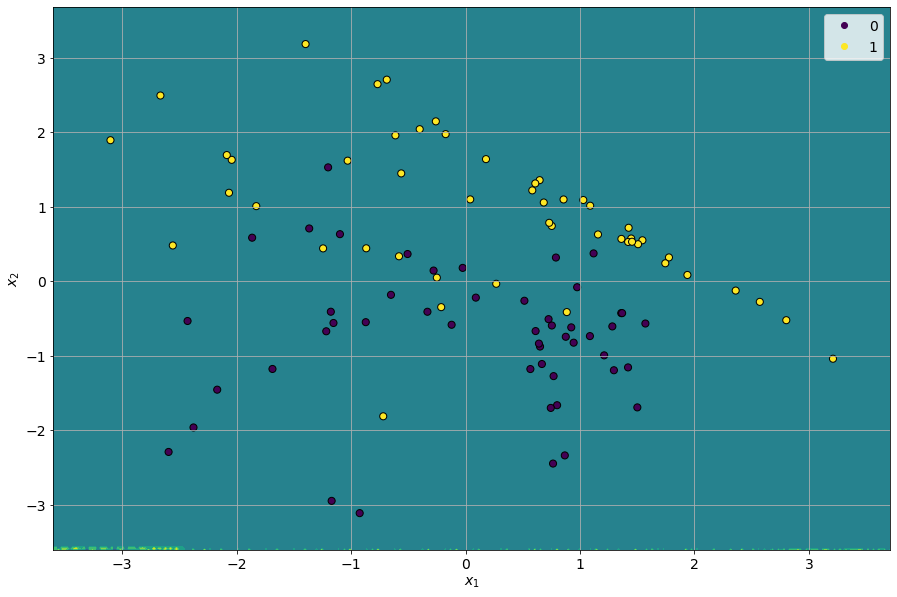

In [63]:
plot_tree_decision_space(X, y_true, bag_tree)